In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

import math
import scipy

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from filter_data import *
from load_and_clean import *
import hdbscan
%matplotlib inline

In [4]:
sys.path.append('../../prgds/src')
from apf.models.prgds import PRGDS

Using numpy backend.


In [5]:
import warnings
warnings.filterwarnings('ignore')

## Pre-processing data

In [6]:
#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

size=14
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
#plt.rcParams.update({'font.size': 14})

In [7]:
#Load and clean all raw data
update_data()
us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, country_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'North Macedonia', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Taiwan*', 'Syria', 'West Bank and Gaza', 'Saint Kitts and Nevis', 'Burma', 'MS Zaandam', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [8]:
#Filter data 
# This part might be to split and explain
# This part might be to split and explain
t = 7

global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1)  
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1) 
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1)
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1)
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

last date
Exceptions are []


In [9]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

### Population adjusted counterfactual analysis

In [63]:
placebo_study = True
if not placebo_study:
    target_states = ['Florida']
    donor_states = northeast
else:
    target_states = ['Massachusetts']
    donor_states = northeast

df = all_cases_data_pop_daily[uscounties_cases_pop_adjusted.columns].loc['2020-03-08':]

donor_counties = []
for state in donor_states:
    donor_counties += list(uscounties.loc[uscounties.state == state].county_state.unique())

target_counties = []
for state in target_states:
    target_counties += list(uscounties.loc[uscounties.state == state].county_state.unique())

df1 = df[df.columns[(df > 10).any()]].copy()
donor_counties = list(df1.columns[df1.columns.isin(donor_counties)])
target_counties = list(df1.columns[df1.columns.isin(target_counties)])

Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties
Intervention date:  2020-05-31


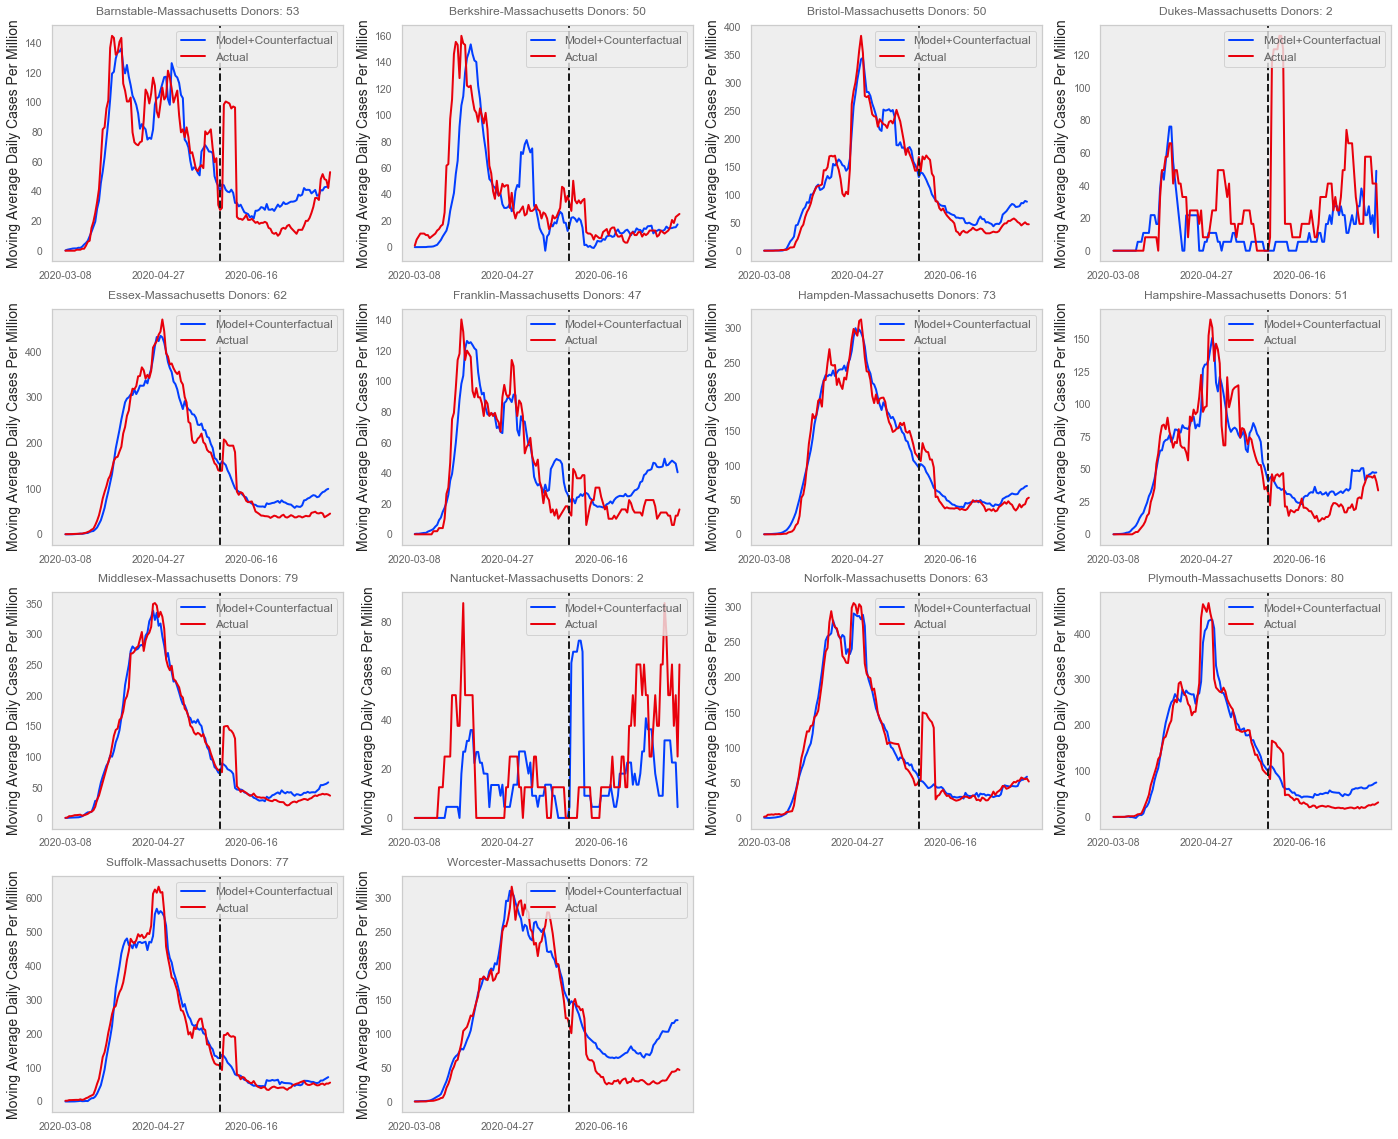

In [174]:
end_t = df.shape[0]
start_t = end_t - 60

trainDF = df.iloc[:start_t,:]
testDF = df.iloc[start_t+1:end_t,:]

targets = target_counties.copy()
donors = donor_counties.copy()

num_rows_to_plot = int(len(targets)/4) + 1
plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams.update({'font.size': 10})

print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")
print("Intervention date: ", testDF.index[0])
for i, county in enumerate(targets):
    other_counties = df.columns[(df.iloc[start_t] < df[county].iloc[start_t] + 0.5 * df[county].iloc[start_t]) & 
                                (df.iloc[start_t] > df[county].iloc[start_t] - 0.5 * df[county].iloc[start_t])]
    other_counties = list(other_counties[other_counties.isin(donors)])
    other_counties = list(filter(lambda x: x != county, other_counties))
    all_rows = list.copy(other_counties) + [county]
    
    rscModel = RobustSyntheticControl(seriesToPredictKey=county, 
                                      kSingularValuesToKeep=4, 
                                      M=len(trainDF), 
                                      probObservation=1.0, 
                                      modelType='svd', 
                                      svdMethod='numpy', 
                                      otherSeriesKeysArray=other_counties)
    rscModel.fit(trainDF)

    denoisedDF = rscModel.model.denoisedDF()
    predictions = np.dot(testDF[other_counties].values, rscModel.model.weights)
    
    model_fit = np.dot(trainDF[other_counties][:], rscModel.model.weights)
    fit_error = mse(model_fit, df[county][:start_t])
    prediction_error = mse(predictions, df[county][start_t+1:])

    ax = plt.subplot(num_rows_to_plot, 4, i+1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.set_title(county + ' Donors: ' + str(len(other_counties)), fontsize=12, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual')
    plt.plot(df[county], label='Actual')
    plt.ylabel('Moving Average Daily Cases Per Million')
    plt.axvline(x=df.index[start_t], color='k', linestyle='--', linewidth=2)
    plt.legend(loc='upper right')
plt.show()


In [59]:
trainDF

,Abbeville-South Carolina,Acadia-Louisiana,Accomack-Virginia,Ada-Idaho,Adair-Iowa,Adair-Kentucky,Adair-Missouri,Adair-Oklahoma,Adams-Colorado,Adams-Idaho,...,York-South Carolina,York-Virginia,Young-Texas,Yuba-California,Yukon-Koyukuk Census Area-Alaska,Yuma-Arizona,Yuma-Colorado,Zapata-Texas,Zavala-Texas,Ziebach-South Dakota
date,,,,,,,,,,,,,,,,,,,,,
2020-03-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2020-03-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2020-03-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2020-03-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2020-03-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552189,0.0,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25,5.824485,96.704005,181.245911,5.636127,39.948865,14.879402,84.554202,45.057223,73.993352,0.0,...,21.353909,12.553352,0.0,0.00000,0.0,167.723682,99.810360,10.075262,24.131274,0.0
2020-05-26,0.000000,306.229350,251.976022,4.746213,39.948865,14.879402,95.828096,32.183730,79.791339,0.0,...,22.370762,16.737802,0.0,0.00000,0.0,189.775003,114.068983,10.075262,24.131274,0.0
2020-05-27,0.000000,310.834302,313.864870,2.669745,59.923298,14.879402,67.643362,25.746984,74.269447,0.0,...,23.387615,16.737802,0.0,0.00000,0.0,221.849651,114.068983,0.000000,12.065637,0.0


In [133]:
n_components = 20
data_TV = np.array(trainDF[target_counties + donor_counties]).astype(int)
assert (data_TV >= 0).all()

model = PRGDS(data_shp=data_TV.shape,
              core_shp=(n_components,),
              time_mode=0,
              stationary=1,
              eps_nu=1.0,
              mtx_is_dirichlet=[],
              seed=617,
              n_threads=1)

n_samples = 20
thin_rate = 50
n_burn_in = 1000

model.fit(data_TV,
          schedule=model.get_default_schedule(),
          verbose=100,
          n_itns=n_burn_in,
          initialize=True)

for s in range(n_samples):
    model.fit(data_TV,
              schedule=model.get_default_schedule(),
              verbose=50,
              n_itns=thin_rate,
              initialize=False)
    state = dict(model.get_state())
    np.savez_compressed('samples/state_%d.npz' % s, **state)
    


INITIALIZING...


STARTING INFERENCE...

0.1011ms: sampling g_K
0.0441ms: sampling beta
0.2789ms: sampling nu_K
0.5240ms: sampling Pi_KK
0.1180ms: sampling tau
0.0792ms: sampling b_T
12.6510ms: sampling H_TKK
0.0031ms: sampling Theta_TK
0.1669ms: sampling delta_T
0.0160ms: sampling b_M
0.4711ms: sampling mtx_MKD
0.0031ms: sampling core_Q
21.3940ms: sampling Y_MKD
0.0238ms: sampling Y_Q
ITERATION 100

0.0031ms: sampling gam
0.1171ms: sampling g_K
0.0479ms: sampling beta
0.1879ms: sampling nu_K
0.2120ms: sampling Pi_KK
0.1171ms: sampling tau
0.2019ms: sampling b_T
12.4412ms: sampling H_TKK
0.0019ms: sampling Theta_TK
0.3693ms: sampling delta_T
0.0250ms: sampling b_M
0.5281ms: sampling mtx_MKD
0.0019ms: sampling core_Q
21.8141ms: sampling Y_MKD
0.0021ms: sampling Y_Q
ITERATION 200

0.0038ms: sampling gam
0.1159ms: sampling g_K
0.0389ms: sampling beta
0.2682ms: sampling nu_K
0.2840ms: sampling Pi_KK
0.1154ms: sampling tau
0.0770ms: sampling b_T
11.9910ms: sampling H_TKK
0.0031ms: sampling

0.1171ms: sampling g_K
0.0439ms: sampling beta
0.0949ms: sampling nu_K
0.2229ms: sampling Pi_KK
0.2282ms: sampling tau
0.2789ms: sampling b_T
11.3971ms: sampling H_TKK
0.0019ms: sampling Theta_TK
0.3479ms: sampling delta_T
0.0172ms: sampling b_M
0.5567ms: sampling mtx_MKD
0.0007ms: sampling core_Q
16.4602ms: sampling Y_MKD
0.0031ms: sampling Y_Q
ITERATION 1650


STARTING INFERENCE...

0.1061ms: sampling g_K
0.0503ms: sampling beta
0.8738ms: sampling nu_K
0.5403ms: sampling Pi_KK
0.5438ms: sampling tau
0.2718ms: sampling b_T
11.6081ms: sampling H_TKK
0.0031ms: sampling Theta_TK
0.3488ms: sampling delta_T
0.0241ms: sampling b_M
0.4759ms: sampling mtx_MKD
0.0019ms: sampling core_Q
20.7858ms: sampling Y_MKD
0.0029ms: sampling Y_Q
ITERATION 1700


STARTING INFERENCE...

0.1669ms: sampling g_K
0.0498ms: sampling beta
0.3390ms: sampling nu_K
0.2651ms: sampling Pi_KK
0.2539ms: sampling tau
0.0911ms: sampling b_T
11.2190ms: sampling H_TKK
0.0026ms: sampling Theta_TK
0.4780ms: sampling delta_T
0

(4, 254)

In [147]:
forecast_TV = model.forecast(n_timesteps=59)
forecast_TP = forecast_TV[:,:len(target_counties)]
forecast_TD = forecast_TV[:,len(target_counties):]

np.sqrt(np.mean((forecast_TP[:1]-test_data_TP[:1])**2))
# np.sqrt(np.mean((forecast_TD-test_data_TD)**2))

# np.sqrt(np.mean((model.reconstruct()-data_TV)**2))

16.352633094652912

In [128]:
from path import Path

for posterior_sample_path in Path('samples').files('state*.npz'):
    posterior_sample = np.load(posterior_sample_path)
    
    Theta_TK = posterior_sample['Theta_TK']    # TxK (time x latent components) matrix
    Phi_VK = posterior_sample['mtx_MKD'][1].T  # VxK (unit x latent components) matrix
    
    Phi_PK = Phi_VK[:len(target_counties)]      # (target units x latent components) sub-matrix
    Phi_DK = Phi_VK[len(target_counties):]      # (donor units x latent components) sub-matrix
    
    pass

In [131]:
from sklearn import linear_model

train_data_TD = np.array(trainDF[donor_counties]).astype(int)
train_data_TP = np.array(trainDF[target_counties]).astype(int)

test_data_TD = np.array(testDF[donor_counties]).astype(int)
test_data_TP = np.array(testDF[target_counties]).astype(int)

up_to = 5

reg = linear_model.Ridge(alpha=0)
reg.fit(train_data_TD.T, test_data_TD[:up_to].T)
print(reg.score(train_data_TD.T, test_data_TD[:up_to].T))
print(reg.score(train_data_TP.T, test_data_TP[:up_to].T))

reg = linear_model.Ridge(alpha=0)
reg.fit(Phi_DK, test_data_TD[:up_to].T)
print(reg.score(Phi_DK, test_data_TD[:up_to].T))

print(reg.score(Phi_PK, test_data_TP[:up_to].T))


# reg.fit(Phi_DK, data_TD[0].T)

# reg.fit(Phi_DK, data_TD[0].T)

# # reg.coef_.shape == (data_TD[].shape[0], 4)
# # pred_PT = reg.predict(Phi_PK)

# print(reg.score(Phi_DK, data_TD[0].T))
# reg.score(Phi_PK, data_TP[0].T)


# for p, target_county in enumerate(target_counties):
#     plt.plot(pred_PT[p])
#     plt.show()

0.9638634550189344
0.8345156200520154
0.8798582971206419
0.43792450959042517


In [173]:
from sklearn.decomposition import PCA

train_data_TV = np.array(trainDF[target_counties + donor_counties]).astype(int)

pca = PCA(n_components=80)
pca.fit(train_data_TV)
pca_Phi_VK = pca.components_.T
pca_Phi_PK = pca_Phi_VK[:len(target_counties)]
pca_Phi_DK = pca_Phi_VK[len(target_counties):]

up_to = 60

reg = linear_model.Ridge(alpha=0)
reg.fit(train_data_TD.T, test_data_TD[:up_to].T)
print(reg.score(train_data_TD.T, test_data_TD[:up_to].T))
print(reg.score(train_data_TP.T, test_data_TP[:up_to].T))

reg = linear_model.Ridge(alpha=0)
reg.fit(pca_Phi_DK, test_data_TD[:up_to].T)
print(reg.score(pca_Phi_DK, test_data_TD[:up_to].T))

print(reg.score(pca_Phi_PK, test_data_TP[:up_to].T))

0.7738569928383742
0.695864299422306
0.7716113029428385
0.6544745915068974


(array([218., 343., 160.,  23.,  17.,  12.,  21.,  15.,   4.,  13.]),
 array([  0. ,  20.7,  41.4,  62.1,  82.8, 103.5, 124.2, 144.9, 165.6,
        186.3, 207. ]),
 <a list of 10 Patch objects>)

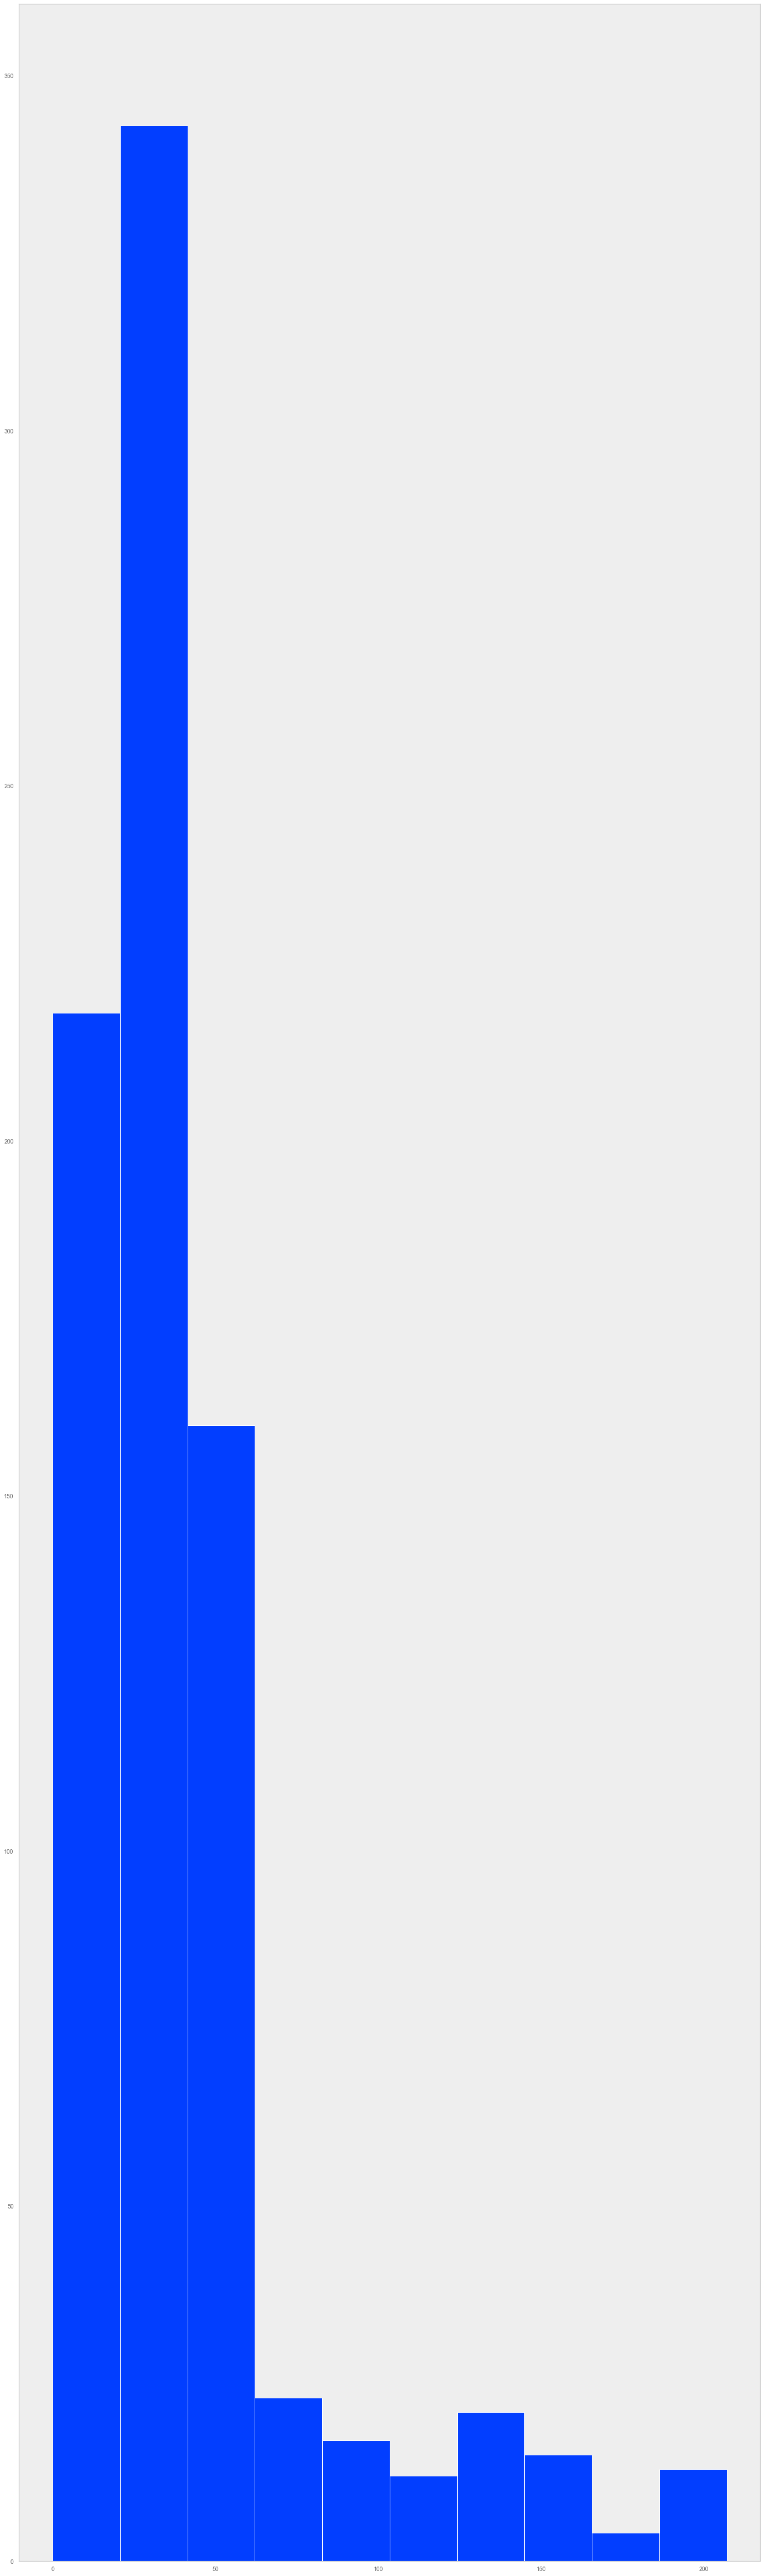

In [126]:
import matplotlib.pyplot as plt
plt.hist(test_data_TP.ravel())

In [83]:
Phi_DK.sum(axis=0)

array([0.94860582, 0.96229029, 0.91569136, 0.95559116])

In [60]:
n_components = 4
data_TV = np.array(testDF[donor_counties]).astype(int)
assert (data_TV >= 0).all()

model = PRGDS(data_shp=data_TV.shape,
              core_shp=(n_components,),
              time_mode=0,
              stationary=1,
              eps_nu=1.0,
              mtx_is_dirichlet=[1],
              seed=617,
              n_threads=1)

n_samples = 20
thin_rate = 50
n_burn_in = 1000

model.fit(data_TV,
          schedule=model.get_default_schedule(),
          verbose=100,
          n_itns=n_burn_in,
          initialize=True)

for s in range(n_samples):
    model.fit(data_TV,
              schedule=model.get_default_schedule(),
              verbose=50,
              n_itns=thin_rate,
              initialize=False)
    state = dict(model.get_state())
    np.savez_compressed('samples/test_state_%d.npz' % s, **state)


INITIALIZING...


STARTING INFERENCE...

0.0830ms: sampling g_K
0.0403ms: sampling beta
0.0691ms: sampling nu_K
0.0689ms: sampling Pi_KK
0.0679ms: sampling tau
0.0582ms: sampling b_T
3.8071ms: sampling H_TKK
0.0021ms: sampling Theta_TK
0.2880ms: sampling delta_T
0.0031ms: sampling b_M
0.2620ms: sampling mtx_MKD
0.0010ms: sampling core_Q
8.3640ms: sampling Y_MKD
0.0029ms: sampling Y_Q
ITERATION 100

0.0041ms: sampling gam
0.1009ms: sampling g_K
0.0408ms: sampling beta
0.0648ms: sampling nu_K
0.0701ms: sampling Pi_KK
0.0730ms: sampling tau
0.0992ms: sampling b_T
3.8269ms: sampling H_TKK
0.0019ms: sampling Theta_TK
0.1249ms: sampling delta_T
0.0031ms: sampling b_M
0.1509ms: sampling mtx_MKD
0.0010ms: sampling core_Q
6.7601ms: sampling Y_MKD
0.0019ms: sampling Y_Q
ITERATION 200

0.0079ms: sampling gam
0.2112ms: sampling g_K
0.0720ms: sampling beta
0.4139ms: sampling nu_K
0.2422ms: sampling Pi_KK
0.0870ms: sampling tau
0.0699ms: sampling b_T
3.7868ms: sampling H_TKK
0.0031ms: sampling Thet

0.0880ms: sampling g_K
0.0520ms: sampling beta
0.0818ms: sampling nu_K
0.0710ms: sampling Pi_KK
0.0703ms: sampling tau
0.0589ms: sampling b_T
3.6762ms: sampling H_TKK
0.0031ms: sampling Theta_TK
0.2971ms: sampling delta_T
0.0021ms: sampling b_M
0.3781ms: sampling mtx_MKD
0.0019ms: sampling core_Q
6.7141ms: sampling Y_MKD
0.0031ms: sampling Y_Q
ITERATION 1650


STARTING INFERENCE...

0.0849ms: sampling g_K
0.0691ms: sampling beta
0.2880ms: sampling nu_K
0.2930ms: sampling Pi_KK
0.1240ms: sampling tau
0.0761ms: sampling b_T
3.8822ms: sampling H_TKK
0.0031ms: sampling Theta_TK
0.1731ms: sampling delta_T
0.0029ms: sampling b_M
0.3431ms: sampling mtx_MKD
0.0019ms: sampling core_Q
6.8338ms: sampling Y_MKD
0.0031ms: sampling Y_Q
ITERATION 1700


STARTING INFERENCE...

0.0882ms: sampling g_K
0.0422ms: sampling beta
0.0679ms: sampling nu_K
0.0718ms: sampling Pi_KK
0.0672ms: sampling tau
0.0589ms: sampling b_T
4.2479ms: sampling H_TKK
0.0031ms: sampling Theta_TK
0.2639ms: sampling delta_T
0.0029

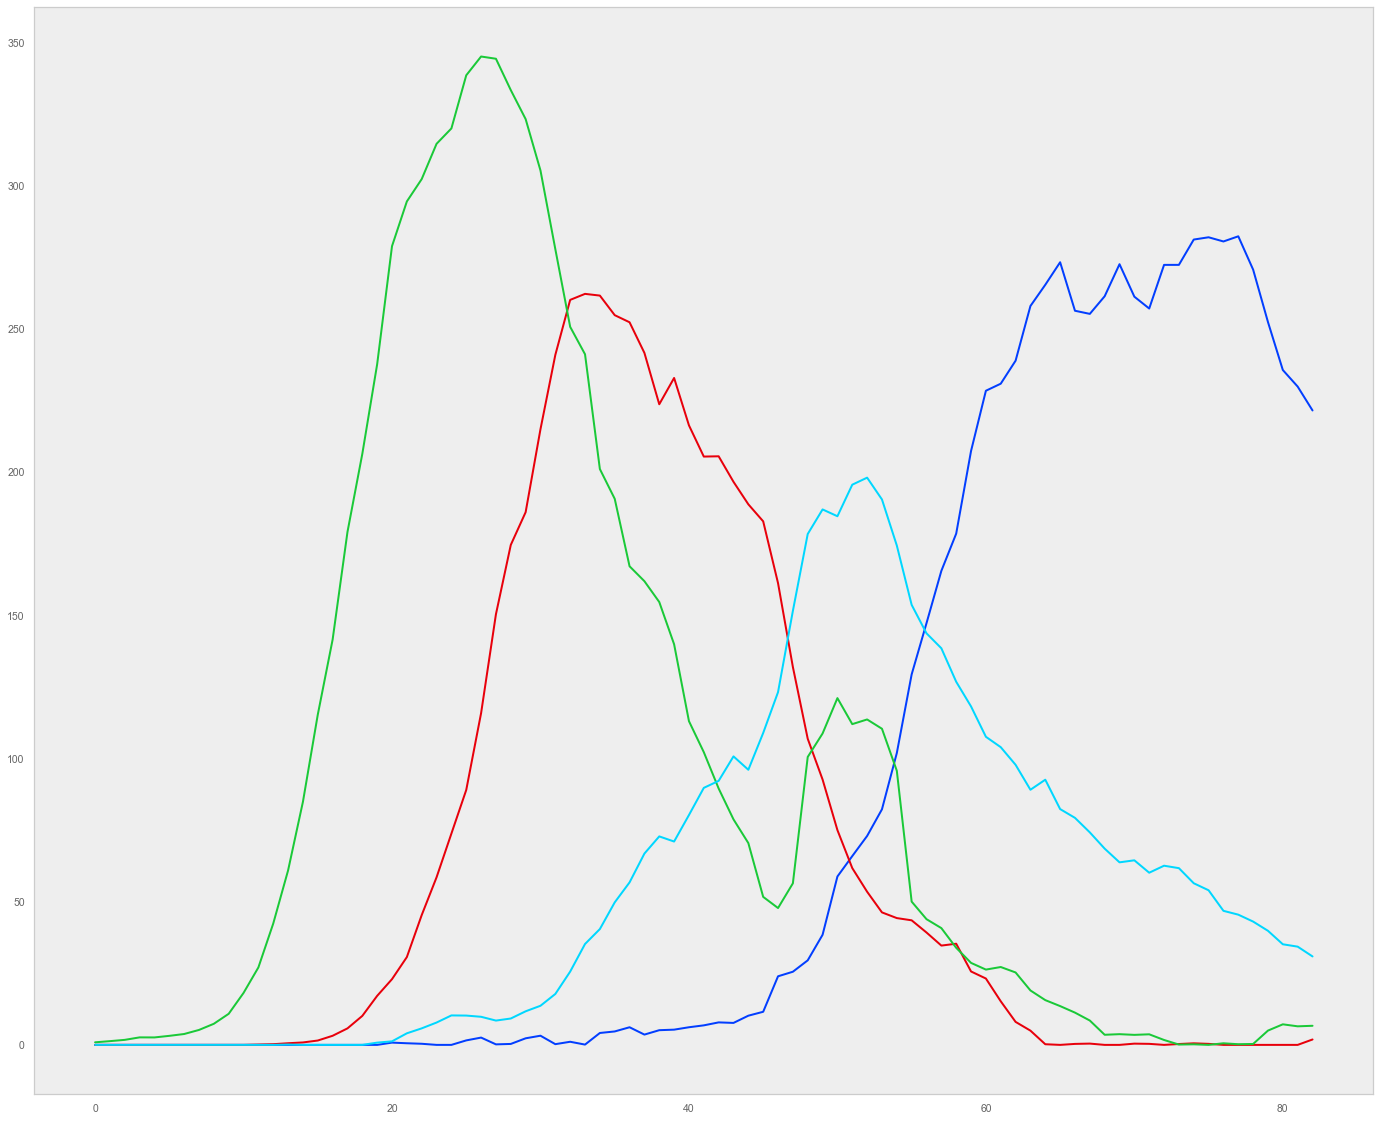

In [39]:
state = dict(model.get_state())
plt.plot(state['Theta_TK'])

In [58]:
(posterior_sample['Theta_TK']==0).mean()

0.25

In [36]:
trainDF[target_counties + donor_counties]

,Barnstable-Massachusetts,Berkshire-Massachusetts,Bristol-Massachusetts,Dukes-Massachusetts,Essex-Massachusetts,Franklin-Massachusetts,Hampden-Massachusetts,Hampshire-Massachusetts,Middlesex-Massachusetts,Nantucket-Massachusetts,...,Windham-Connecticut,Windham-Vermont,Windsor-Vermont,Worcester-Maryland,Worcester-Massachusetts,Wyoming-New York,Wyoming-Pennsylvania,Yates-New York,York-Maine,York-Pennsylvania
date,,,,,,,,,,,,,,,,,,,,,
2020-03-08,0.000000,1.143369,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.886376,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.171988,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-09,0.000000,5.716847,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.329564,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.171988,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-10,0.000000,8.003586,0.000000,0.000000e+00,0.181053,0.000000,0.000000,0.000000,3.634142,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.171988,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-11,0.000000,10.290324,0.000000,0.000000e+00,0.181053,0.000000,0.000000,0.000000,3.634142,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.343976,0.000000,0.000000,0.000000,0.000000,0.000000
2020-03-12,0.000000,10.290324,0.000000,0.000000e+00,0.362106,0.000000,0.000000,0.000000,4.254605,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.343976,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25,81.828121,29.727604,173.131988,8.120488e-15,178.880577,12.213492,150.401090,53.294961,105.833303,1.253243e+01,...,52.601061,13.533906,7.783434,60.120460,182.823406,10.752187,15.995052,68.810890,33.024031,23.223217
2020-05-26,69.084397,45.734775,165.044070,8.120488e-15,166.931065,14.249074,141.211614,53.294961,97.235455,1.253243e+01,...,55.047622,10.150429,7.783434,84.715193,167.688448,10.752187,15.995052,63.076650,35.776034,24.495722
2020-05-27,59.694285,44.591406,155.186921,8.120488e-15,155.343659,16.284656,130.796875,45.300717,88.460332,1.253243e+01,...,51.377781,10.150429,7.783434,71.051452,149.113728,10.752187,15.995052,28.671204,33.712032,26.722606


In [37]:
len(target_counties + donor_counties)

254